In [1]:
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import swat

This tutorial assumes that you are already familiar with the Seqential API. The tutorial would introduce an alternate way, Network API which is very similar to Keras functional API. 

The reason we have it is that Network API provides you with a more flexiable way to implemnt complex models. Seqential API is limited in that it does not allow you to create models that share layers or have multiple inputs or outputs(multiple outputs will be supported after VIYA 3.5). 

In [3]:
host_name='your_host_name'
port_number='your_port_number'
sess = swat.CAS( 'dlgrd009', 13300)

In [7]:
import sys
sys.path.append('C:\\Users\\weshiz\\Documents\\GitHub\\modify\python-dlpy')
from dlpy.network import *
from dlpy.layers import *

To use the Network API, create your input and output layers and then pass them to the Network() function. 

Here's a good example for the Network API: models with multiple inputs and outputs. Let's consider the following model. We define two image sources, grayscale image and RGB image as inputs. The grayscale image is feeded into two convolutional branchs. The model will also have another input, color image. Then a convolutional layer is used for extracting feature of the image. By far all of feature are ready. Three edges connect to a concatenation layer and then OutputLayer_1 calculate a classification loss. Also the model is supervised via OutputLayer_2.

In [13]:
input1 = InputLayer(n_channels = 1, width = 28, height = 28)
input2 = InputLayer(n_channels = 3, width = 28, height = 28)
conv1 = Conv2d(2)(Conv2d(2)(input1))
conv2 = Conv2d(2)(input1)
conv3 = Conv2d(2)(input2)
output2 = OutputLayer(n=2)(conv3)
concat1 = Concat(src_layers = [conv1, conv2, conv3])
output1 = OutputLayer(n=2)(concat1)

Pass defined inputs and outputs to the Network() function. Then call compile() to compile the network.

In [14]:
model1 = Network(conn = sess, inputs = [input1, input2], outputs = [output1, output2])
model1.compile()
model1.print_summary()

NOTE: Model compiled successfully.


,Layer,Type,Kernel Size,Stride,Activation,Output Size,Number of Parameters
0,OutputLayer_8,output,"(4704, 2)",None,Softmax,2,"(9408, 2)"
1,Concat_2,concat,None,None,Auto,"(28, 28, 6)","(0, 0)"
2,Conv2d_14,convo,"(3, 3)",1,Relu,"(28, 28, 2)","(36, 2)"
3,Conv2d_13,convo,"(3, 3)",1,Relu,"(28, 28, 2)","(18, 2)"
4,InputLayer_3,input,None,None,None,"(28, 28, 1)","(0, 0)"
5,Conv2d_15,convo,"(3, 3)",1,Relu,"(28, 28, 2)","(18, 2)"
6,Conv2d_16,convo,"(3, 3)",1,Relu,"(28, 28, 2)","(54, 2)"
7,InputLayer_4,input,None,None,None,"(28, 28, 3)","(0, 0)"
8,OutputLayer_7,output,"(1568, 2)",None,Softmax,2,"(3136, 2)"
9,,,,,,,12682


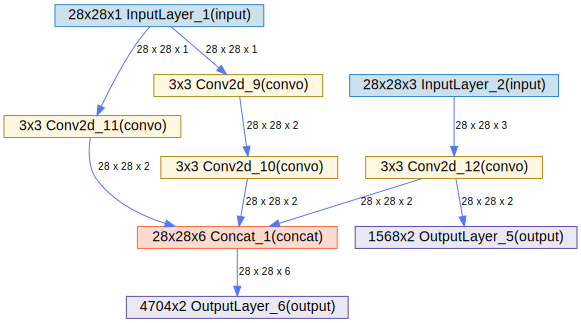

In [11]:
model1.plot_network()

This model can be trained just like sequential models.

In [ ]:
# train the model via:
model1.fit()

In the next model, let's consider how to build a residual block.

In [15]:
def conv_block(x, filters, size, stride=1, mode='same', act=True):
    x = Conv2d(filters, size, size, act='identity', include_bias=False, stride=stride)(x)
    x = BN(act='relu' if act else 'identity')(x)
    return x

In [16]:
def res_block(ip, nf=64):
    x = conv_block(ip, nf, 3, 1)
    x = conv_block(x, nf, 3, 1, act=False)
    return Res(src_layers = [x, ip])

In [19]:
inp= InputLayer(1, 32, 32, scale = 1.0 / 255, name='InputLayer_1')
x=conv_block(inp, 64, 9, 1)
for i in range(4): x=res_block(x)
x=Conv2d(1, 9, 9, act='tanh')(x)
output = OutputLayer(n=100)(x)
model = Network(sess, inputs = inp, outputs = output)
model.compile()

NOTE: Model compiled successfully.


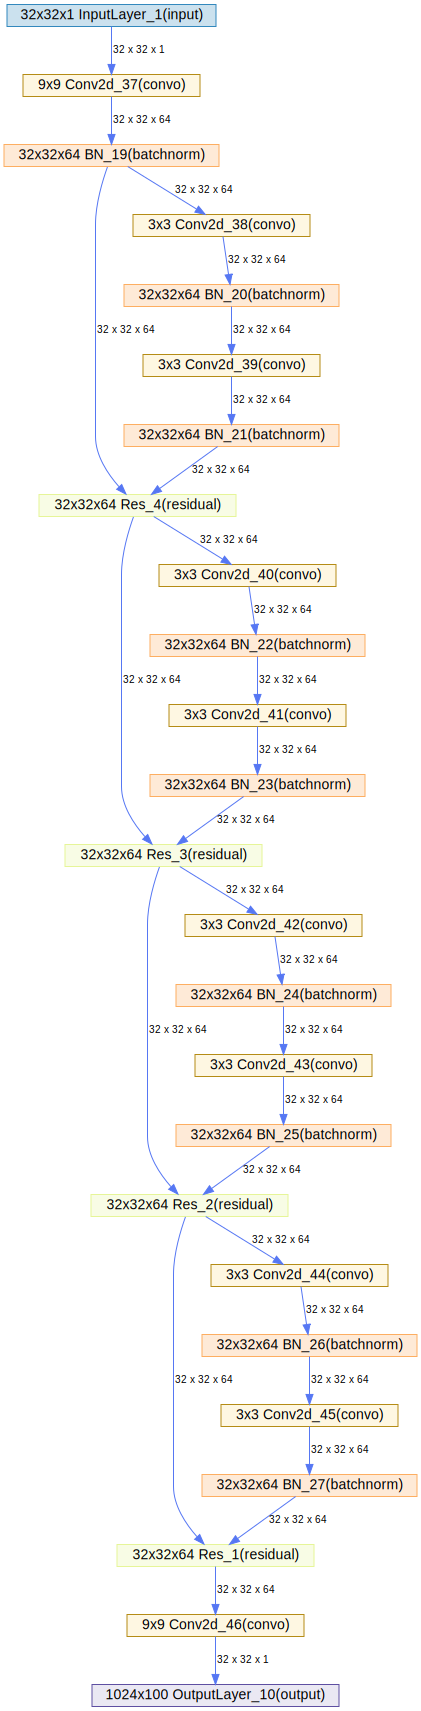

In [20]:
model.plot_network()